# **1.1 Star Schema**

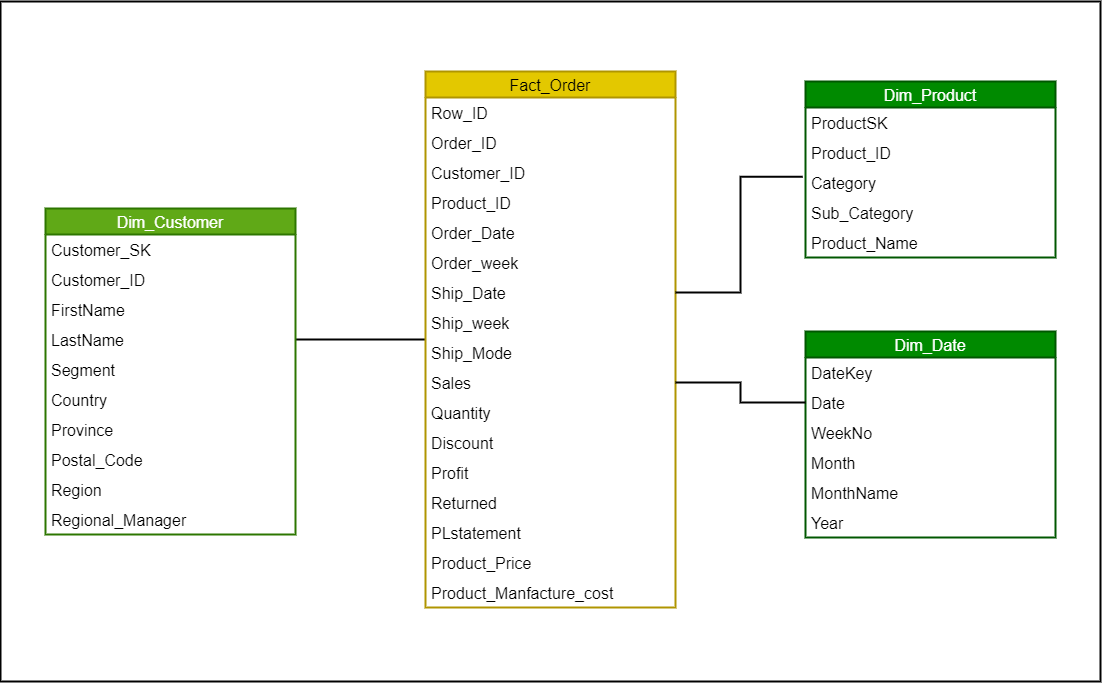

# **1.2 Environment implementation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install pyspark
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
# Import a Spark function from library
from pyspark.sql.functions import col




# **1.3 EXTRACT**

**Load Data into DataFrames**

In [ ]:

import pandas as pd
pdf = pd.read_csv('/content/drive/MyDrive/Surge_Assignment/GS_SALES.csv')

#Spark cannot handle Columns Which Has Commas, So That I am using  .option("quote", "\"").option("escape", "\"") 

SalesDf = spark.read.format("csv").option("header", "true").option("quote", "\"").option("escape", "\"").load("/content/drive/MyDrive/Surge_Assignment/GS_SALES.csv")
SalesDf = SalesDf.toPandas()
SalesDf['Order Date']=pd.to_datetime(SalesDf['Order Date'])
SalesDf['Ship Date']=pd.to_datetime(SalesDf['Ship Date'])

SalesDf=spark.createDataFrame(SalesDf) 


**Print current Schema**

In [ ]:
SalesDf.printSchema()


root
 |-- Row ID: string (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: timestamp (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: timestamp (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- Profit: string (nullable = t

**Renaming Column Names**

In [ ]:
SalesDf=SalesDf.withColumnRenamed("Order Date","Order_Date") \
                        .withColumnRenamed("Ship Date","Ship_Date") \
                        .withColumnRenamed("Ship Mode","Ship_Mode")\
                        .withColumnRenamed("Customer ID","Customer_ID")\
                        .withColumnRenamed("Customer Name","Customer_Name")\
                        .withColumnRenamed("Country/Region","Country")\
                        .withColumnRenamed("Postal Code","Postal_Code")\
                        .withColumnRenamed("Regional Manager","Regional_Manager")\
                        .withColumnRenamed("Sub-Category","Sub_Category")\
                        .withColumnRenamed("Product Name","Product_Name")\
                        .withColumnRenamed("State/Province","Province")\
                        .withColumnRenamed("Row ID","Row_ID")\
                        .withColumnRenamed("Order ID","Order_ID")\
                        .withColumnRenamed("Product ID","Product_ID")               


# **1.4 Verify Data Schema and Casting Fields**

**Casting Columns to correct data types**

In [ ]:
from pyspark.sql.types import IntegerType,DateType,FloatType
from pyspark.sql.functions import *
#We can keep Postal Code As String Because We are not doing mathematical tasks on postal code

FinalSalesDf=SalesDf.withColumn("Discount",SalesDf.Discount.cast(FloatType())) \
                    .withColumn("Quantity",SalesDf.Quantity.cast(IntegerType()))\
                    .withColumn("Sales",SalesDf.Sales.cast(FloatType()))\
                    .withColumn("Profit",SalesDf.Profit.cast(FloatType()))\
                    .withColumn("Row_ID",SalesDf.Row_ID.cast(IntegerType()))\
                    .withColumn("Order_Date", SalesDf.Order_Date.cast(DateType()))\
                    .withColumn("Ship_Date",SalesDf.Ship_Date.cast(DateType()))\

                    
                    




**Printing Final Schema**

In [ ]:
FinalSalesDf.printSchema()
FinalSalesDf.show()
#Creating Temporary View
FinalSalesDf.createOrReplaceTempView("Sales_Data")



root
 |-- Row_ID: integer (nullable = true)
 |-- Order_ID: string (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship_Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship_Mode: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Postal_Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional_Manager: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product_Name: string (nullable = true)
 |-- Sales: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: float (nullable = true)
 |-- Profit: float (nullable = true)
 |-- Returned: stri

# **1.5 Create Data Ware house**

# **LOAD**

**Dimension Table Creation**

In [ ]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import monotonically_increasing_id

CustomerSchema = StructType([
         StructField('Customer_ID', StringType(),True),
         StructField('Customer_Name', StringType(), True),
         StructField('Segment', StringType(), True),
         StructField('Country', StringType(), True),
         StructField('Province', StringType(), True),
         StructField('Postal_Code', StringType(), True),
         StructField('Region', StringType(), True),
         StructField('Regional_Manager', StringType(), True)
    ])
CustomerData =  spark.sql("""SELECT DISTINCT Customer_ID, Customer_Name, Segment, Country, Province,Postal_Code,Region,Regional_Manager
                            FROM Sales_Data
                             """)

DimCustomer = spark.createDataFrame(data=CustomerData.collect(),schema=CustomerSchema)

#Surrogate Key Generation

DimCustomer = DimCustomer.withColumn("Customer_SK",monotonically_increasing_id()+1)

#Schema Of Dimension Customer
DimCustomer.printSchema()
#Top 20 Record of Dimension Customer
DimCustomer.show(20)


root
 |-- Customer_ID: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Postal_Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional_Manager: string (nullable = true)
 |-- Customer_SK: long (nullable = false)

+-----------+------------------+-----------+-------------+--------------+-----------+-------+-----------------+-----------+
|Customer_ID|     Customer_Name|    Segment|      Country|      Province|Postal_Code| Region| Regional_Manager|Customer_SK|
+-----------+------------------+-----------+-------------+--------------+-----------+-------+-----------------+-----------+
|   HF-14995|   Herbert Flentye|   Consumer|United States|    California|      90008|   West|  Sadie Pawthorne|          1|
|   GT-14635|    Grant Thornton|  Corporate|United States|      New York|      11561|   East|      Chuck Magee|          

In [ ]:
ProductSchema = StructType([
    StructField('Product_ID',StringType(),True),
    StructField('Category',StringType(),True),
    StructField('Sub_Category',StringType(),True),
    StructField('Product_Name',StringType(),True)

])


ProductData =  spark.sql("""SELECT DISTINCT Product_ID, Category, Sub_Category, Product_Name
                            FROM Sales_Data
                             """) 

DimProduct = spark.createDataFrame(data=ProductData.collect(),schema=ProductSchema)
DimProduct = DimProduct.withColumn("Product_SK",monotonically_increasing_id()+1)
DimProduct.printSchema()

DimProduct.show(20,False) 


root
 |-- Product_ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product_Name: string (nullable = true)
 |-- Product_SK: long (nullable = false)

+---------------+---------------+------------+-------------------------------------------------------------------------------------------------------------+----------+
|Product_ID     |Category       |Sub_Category|Product_Name                                                                                                 |Product_SK|
+---------------+---------------+------------+-------------------------------------------------------------------------------------------------------------+----------+
|TEC-PH-10001552|Technology     |Phones      |I Need's 3d Hello Kitty Hybrid Silicone Case Cover for HTC One X 4g with 3d Hello Kitty Stylus Pen Green/pink|1         |
|OFF-AR-10001953|Office Supplies|Art         |Boston 1645 Deluxe Heavier-Duty Electric Pencil Sharpener        

**Fact Table Creation**

In [ ]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,FloatType
OrderSchema = StructType([
         StructField('Row_ID', IntegerType(),False),
         StructField('Order_ID', StringType(),True),
         StructField('Customer_ID', StringType(), True),
         StructField('Product_ID', StringType(), True),
         StructField('Order_Date', DateType(), True),
         StructField('Order_Week', StringType(), True),
         StructField('Ship_Date', DateType(), True),
         StructField('Ship_Week', StringType(), True),
         StructField('Ship_Mode', StringType(), True),
         StructField('Sales', FloatType(), True),
         StructField('Quantity', IntegerType(), True),
         StructField('Discount', FloatType(), True),
         StructField('Profit', FloatType(), True),
         StructField('Returned', StringType(), True)
    ])


OrderData =  spark.sql("""SELECT Row_ID, Order_ID, Customer_ID, Product_ID,Order_Date,Order_Week,Ship_Date,Ship_Week,Ship_Mode,Sales,Quantity,Discount,Profit,Returned
                            FROM Sales_Data
                             """)

FactOrder = spark.createDataFrame(data=OrderData.collect(),schema=OrderSchema)

FactOrder.printSchema()
 
FactOrder.show(20)

root
 |-- Row_ID: integer (nullable = false)
 |-- Order_ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship_Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship_Mode: string (nullable = true)
 |-- Sales: float (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: float (nullable = true)
 |-- Profit: float (nullable = true)
 |-- Returned: string (nullable = true)

+------+--------------+-----------+---------------+----------+----------+----------+---------+--------------+-------+--------+--------+--------+--------+
|Row_ID|      Order_ID|Customer_ID|     Product_ID|Order_Date|Order_Week| Ship_Date|Ship_Week|     Ship_Mode|  Sales|Quantity|Discount|  Profit|Returned|
+------+--------------+-----------+---------------+----------+----------+----------+---------+--------------+-------+--------

# **2.TRANSFORM**

**Dim Customer Transformation**


> Data Enrichment

* Full Name to - First , Last


> Data Cleansing

* Handling NULL values







In [ ]:

DimCustomer.withColumn("tmp",split(col("Customer_Name"),"\s+")).\
withColumn("FirstName",col("tmp").getItem(0)).\
withColumn("LastName",col("tmp").getItem(1)).\
drop("tmp").drop("Customer_Name").show()



+-----------+-----------+-------------+--------------+-----------+-------+-----------------+-----------+---------+---------+
|Customer_ID|    Segment|      Country|      Province|Postal_Code| Region| Regional_Manager|Customer_SK|FirstName| LastName|
+-----------+-----------+-------------+--------------+-----------+-------+-----------------+-----------+---------+---------+
|   HF-14995|   Consumer|United States|    California|      90008|   West|  Sadie Pawthorne|          1|  Herbert|  Flentye|
|   GT-14635|  Corporate|United States|      New York|      11561|   East|      Chuck Magee|          2|    Grant| Thornton|
|   HK-14890|  Corporate|United States|      Michigan|      48234|Central|Roxanne Rodriguez|          3|  Heather| Kirkland|
|   DJ-13510|  Corporate|United States|      Arkansas|      72209|  South|      Fred Suzuki|          4|      Don|    Jones|
|   FC-14335|  Corporate|United States|    New Mexico|      87105|   West|  Sadie Pawthorne|          5|     Fred|    Chung|


**Checking null values in columns**

In [ ]:

for i in range(len(DimCustomer.columns)):
     num=  DimCustomer.filter(DimCustomer[i].isNull()).count()
     if (num > 0 ):
       print("Col Name {}".format(DimCustomer[i]))


**Dim Product Transformation**

> Data Cleansing

* Handling NULL values
* Handling Missing values


In [ ]:
for i in range(len(DimProduct.columns)):
     num=  DimProduct.filter(DimProduct[i].isNull()).count()
     if (num > 0 ):
       print("Col Name {}".format(DimProduct[i]))





**Handling Missing Values**

In [ ]:
DimProduct.select('Category').distinct().show()

DimProduct = DimProduct.withColumn("Category", when(DimProduct.Category == "#N/A","Other") \
      .otherwise(DimProduct.Category))
DimProduct.show()

DimProduct.select('Category').distinct().show()


+---------------+
|       Category|
+---------------+
|Office Supplies|
|      Furniture|
|           #N/A|
|     Technology|
+---------------+

+---------------+---------------+------------+--------------------+----------+
|     Product_ID|       Category|Sub_Category|        Product_Name|Product_SK|
+---------------+---------------+------------+--------------------+----------+
|TEC-PH-10001552|     Technology|      Phones|I Need's 3d Hello...|         1|
|OFF-AR-10001953|Office Supplies|         Art|Boston 1645 Delux...|         2|
|TEC-AC-10001767|     Technology| Accessories|SanDisk Ultra 64 ...|         3|
|OFF-PA-10001937|Office Supplies|       Paper|            Xerox 21|         4|
|OFF-PA-10003039|Office Supplies|       Paper|          Xerox 1960|         5|
|OFF-EN-10000483|Office Supplies|   Envelopes|White Envelopes, ...|         6|
|FUR-BO-10004360|      Furniture|   Bookcases|Rush Hierlooms Co...|         7|
|TEC-AC-10001314|     Technology| Accessories|Case Logic 2.4GHz..

**Fact Table Transformation**


> Data Cleansing
* Handling NULL values
* Handling Missing values

> Application of business logic
* Calculation
* Derived Columns (***PLstatement ,Product_Price ,Product_Manufacture_cost***)



In [ ]:
FactOrder = FactOrder.withColumn('PLstatement',\
     when(\
     col('Profit') > 0,\
     lit('Profit')).\
     otherwise(lit('Loss')))


In [ ]:
#remove rows where all our columns are NaN.
FactOrder = FactOrder.na.drop(how = 'all') # filter out nulls


In [ ]:
for i in range(len(FactOrder.columns)):
     num=  FactOrder.filter(FactOrder[i].isNull()).count()
     if (num > 0 ):
       print("Col Name {}".format(FactOrder[i]))


In [ ]:
#Check Distinct Values Of Returned
#FactOrder.select("Returned").distinct().show()

FactOrder = FactOrder.withColumn('Returned',\
     when(\
     col('Returned') == 'Yes',\
     lit('Yes')).\
     otherwise(lit('No')))

FactOrder.show()


+------+--------------+-----------+---------------+----------+----------+----------+---------+--------------+-------+--------+--------+--------+--------+-----------+
|Row_ID|      Order_ID|Customer_ID|     Product_ID|Order_Date|Order_Week| Ship_Date|Ship_Week|     Ship_Mode|  Sales|Quantity|Discount|  Profit|Returned|PLstatement|
+------+--------------+-----------+---------------+----------+----------+----------+---------+--------------+-------+--------+--------+--------+--------+-----------+
|     1|US-2019-103800|   DP-13000|OFF-PA-10000174|2019-01-03|    2019-1|2019-01-07|   2019-2|Standard Class| 16.448|       2|     0.2|  5.5512|      No|     Profit|
|     2|US-2019-112326|   PO-19195|OFF-BI-10004094|2019-01-04|    2019-1|2019-01-08|   2019-2|Standard Class|   3.54|       2|     0.8|  -5.487|      No|       Loss|
|     3|US-2019-112326|   PO-19195|OFF-LA-10003223|2019-01-04|    2019-1|2019-01-08|   2019-2|Standard Class| 11.784|       3|     0.2|  4.2717|      No|     Profit|
|   

In [ ]:
FactOrder = FactOrder.withColumn('Product_Price',\
     lit( round((FactOrder.Sales /(1-FactOrder.Discount)) /FactOrder.Quantity ,2)))



In [ ]:
FactOrder = FactOrder.withColumn('Product_Manufacture_cost',\
     lit( round(((FactOrder.Product_Price *FactOrder.Quantity)- FactOrder.Profit)/FactOrder.Quantity,2)))

FactOrder.show()

+------+--------------+-----------+---------------+----------+----------+----------+---------+--------------+-------+--------+--------+--------+--------+-----------+-------------+------------------------+
|Row_ID|      Order_ID|Customer_ID|     Product_ID|Order_Date|Order_Week| Ship_Date|Ship_Week|     Ship_Mode|  Sales|Quantity|Discount|  Profit|Returned|PLstatement|Product_Price|Product_Manufacture_cost|
+------+--------------+-----------+---------------+----------+----------+----------+---------+--------------+-------+--------+--------+--------+--------+-----------+-------------+------------------------+
|     1|US-2019-103800|   DP-13000|OFF-PA-10000174|2019-01-03|    2019-1|2019-01-07|   2019-2|Standard Class| 16.448|       2|     0.2|  5.5512|      No|     Profit|        10.28|                     7.5|
|     2|US-2019-112326|   PO-19195|OFF-BI-10004094|2019-01-04|    2019-1|2019-01-08|   2019-2|Standard Class|   3.54|       2|     0.8|  -5.487|      No|       Loss|         8.85| 

# **3.Data Visualization**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



**Total Sales across Province**

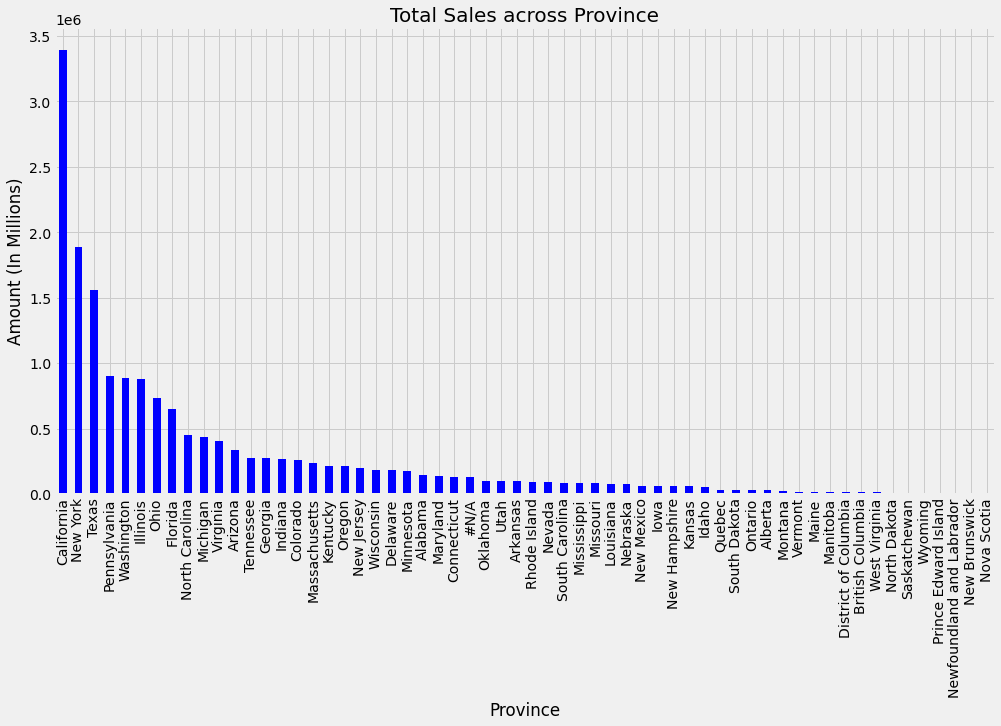

In [ ]:
FactOrder.createOrReplaceTempView("FactOrder")
DimCustomer.createOrReplaceTempView("DimCustomer")

df = spark.sql(" SELECT Sales, Profit ,Region,Quantity ,Province FROM FactOrder f left join DimCustomer c ON (f.Customer_ID = c.Customer_ID) ") 

import numpy as np
df= df.toPandas()

df_province_sales= df.groupby('Province')['Sales'].sum().sort_values(ascending = False).plot.bar(figsize = (15, 8), color = 'b') 
plt.xlabel("Province")
plt.ylabel("Amount (In Millions)")
plt.title("Total Sales across Province", fontsize = 20)
plt.show()



**Total Profit/Loss across Province**

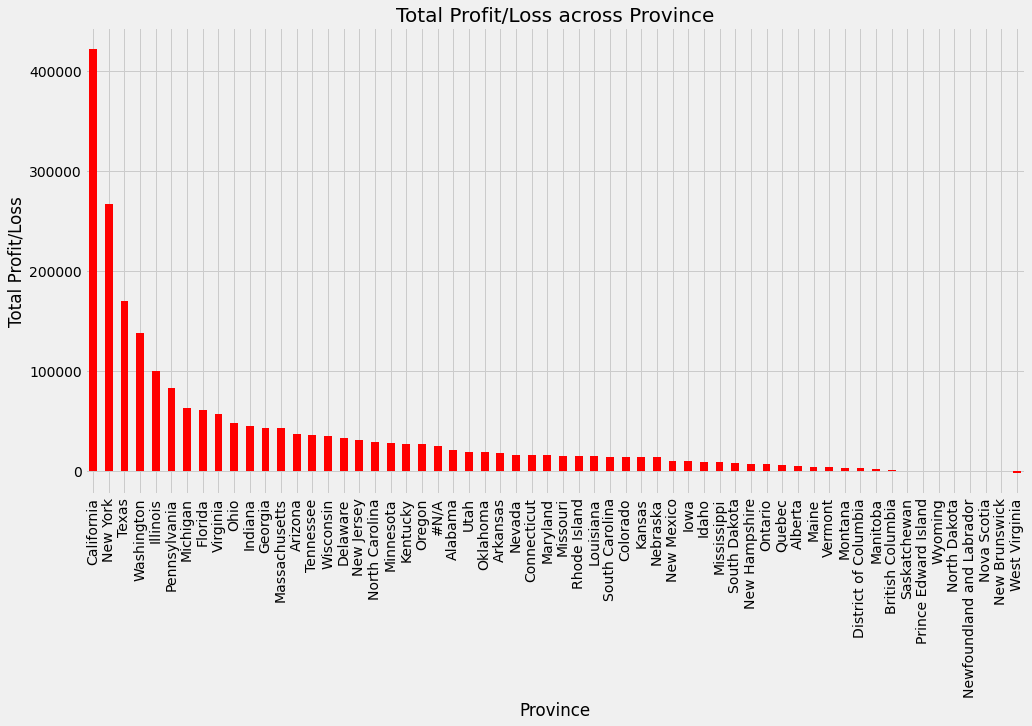

In [ ]:
df.groupby('Province')['Profit'].sum().sort_values(ascending = False).plot.bar(figsize = (15, 8), color = 'r') 
plt.xlabel("Province")
plt.ylabel("Total Profit/Loss")
plt.title("Total Profit/Loss across Province", fontsize = 20)
plt.show()


**Sales and Profitabilty across Product Sub-Category**

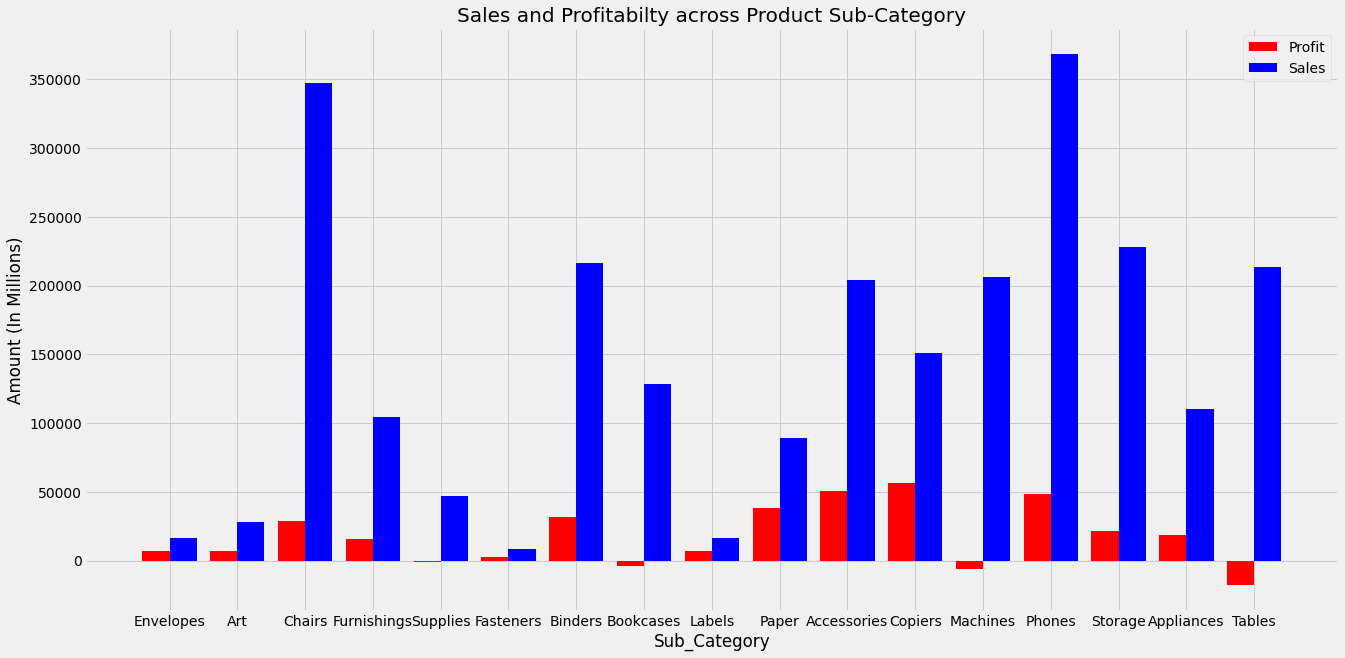

In [ ]:
DimProduct.createOrReplaceTempView("DimProduct")
df = spark.sql(" SELECT sum(Sales), sum(Profit) , Sub_Category FROM FactOrder f left join DimProduct p ON (f.Product_ID = p.Product_ID) group by Sub_Category ") 


df= df.toPandas()
x_axis = np.arange(len(df.Sub_Category.value_counts()))

plt.figure(figsize = (20, 10))
plt.bar(x_axis-0.2, df['sum(Profit)'] , width=0.4, color='r')
plt.bar(x_axis+0.2, df['sum(Sales)'],width=0.4,color='b')

plt.xticks(x_axis, df.Sub_Category)
plt.xlabel("Sub_Category")
plt.ylabel("Amount (In Millions)")
plt.legend(["Profit", "Sales"])
plt.title("Sales and Profitabilty across Product Sub-Category", fontsize = 20)
plt.show()


**Observation between Discount and Profit**

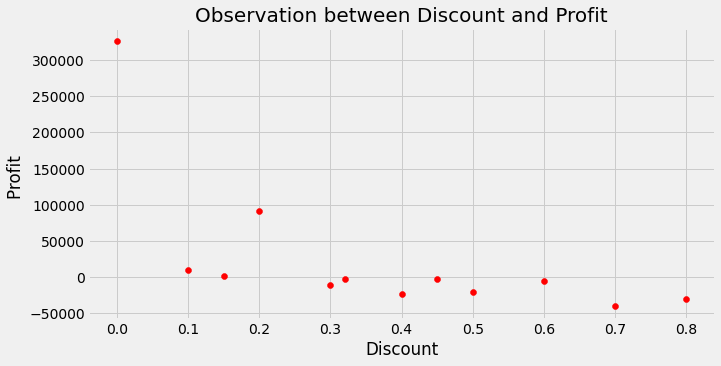

In [ ]:
Df = spark.sql(""" select sum(Profit),Discount from FactOrder group by Discount """)
df1 = np.array(Df.select('Discount').collect())
df2 = np.array(Df.select('sum(Profit)').collect())
plt.figure(figsize = (10, 5))
plt.scatter(df1,df2 ,color = 'r' )
plt.xlabel("Discount")
plt.ylabel("Profit ")

plt.title("Observation between Discount and Profit", fontsize = 20)
plt.show()

**Total Number Of Quantity Sold**

> Region Wise Analysis

> Category Wise Analysis







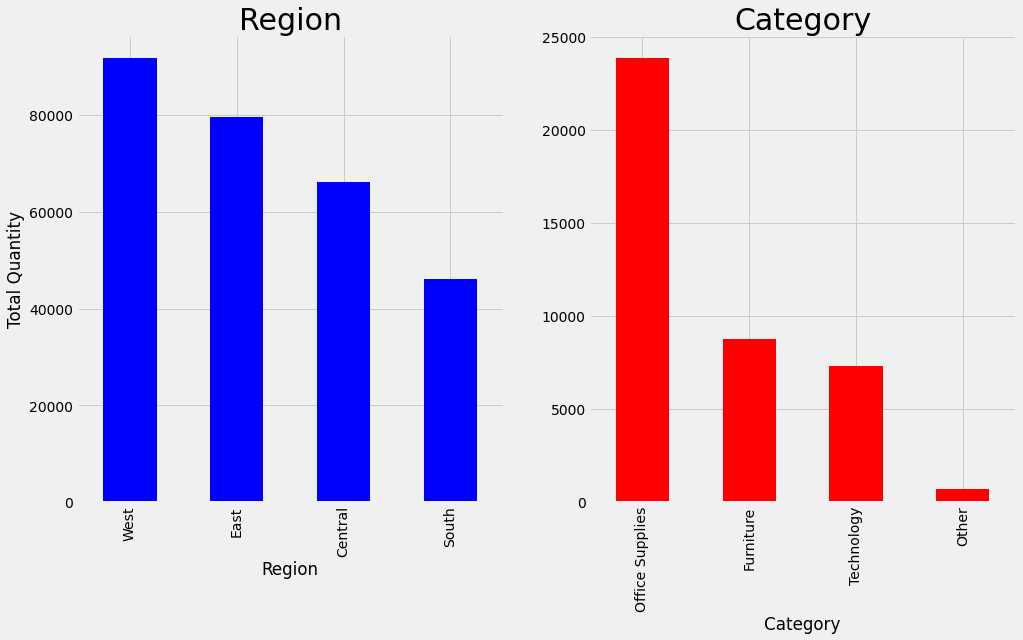

In [ ]:
df1 = spark.sql(" SELECT Region, Quantity  FROM FactOrder f left join DimCustomer c ON (f.Customer_ID = c.Customer_ID) ") 
df2 = spark.sql(" SELECT Category, Quantity  FROM FactOrder f left join DimProduct p ON (f.Product_ID = p.Product_ID) ") 
import numpy as np
df1= df1.toPandas()
df2 =df2.toPandas()

plt.subplot(1, 2, 1)
df_province_sales= df1.groupby('Region')['Quantity'].sum().sort_values(ascending = False).plot.bar(figsize = (15, 8), color = 'b') 
plt.ylabel("Total Quantity")
plt.title("Region", fontsize = 30)

plt.subplot(1, 2, 2)
df_province_sales= df2.groupby('Category')['Quantity'].sum().sort_values(ascending = False).plot.bar(figsize = (15, 8), color = 'r') 
plt.title("Category", fontsize = 30)

plt.show()




# **Predict future Sales Using ARIMA MODEL**

> By Changing this ' where **Segment='Corporate'** ' Query We can Generate for other segments


In [ ]:
import pandas as pd
import matplotlib.pylab as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,8

df = spark.sql(""" SELECT  sum(Quantity) as Quantities,Ship_Date FROM FactOrder f left join DimCustomer c ON (f.Customer_ID = c.Customer_ID) where Segment='Corporate' group by Segment , Ship_Date """) 
df=df.toPandas()
df.sort_values(by=['Ship_Date'], inplace=True)


df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], format='%Y-%m')
df['Ship_Date'].dtypes

df.index = df['Ship_Date']
del df['Ship_Date']
df.head()



,Quantities
Ship_Date,
2019-01-07,27
2019-01-15,258
2019-01-21,24
2019-01-24,176
2019-01-26,9


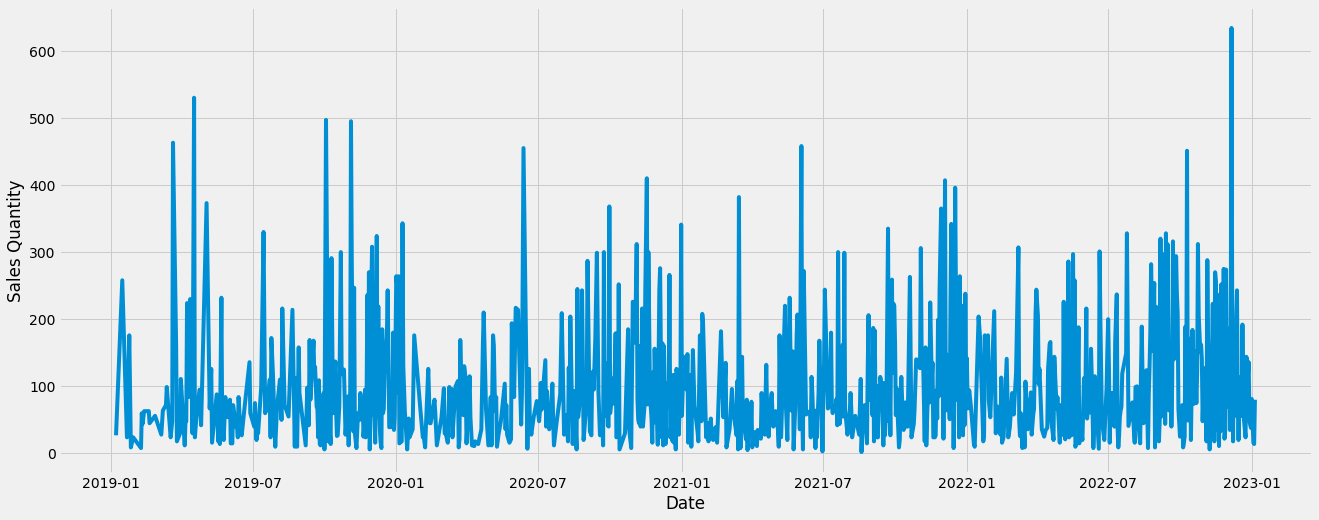

In [ ]:
plt.xlabel("Date")
plt.ylabel('Sales Quantity')
plt.plot(df)

**Decomposing**

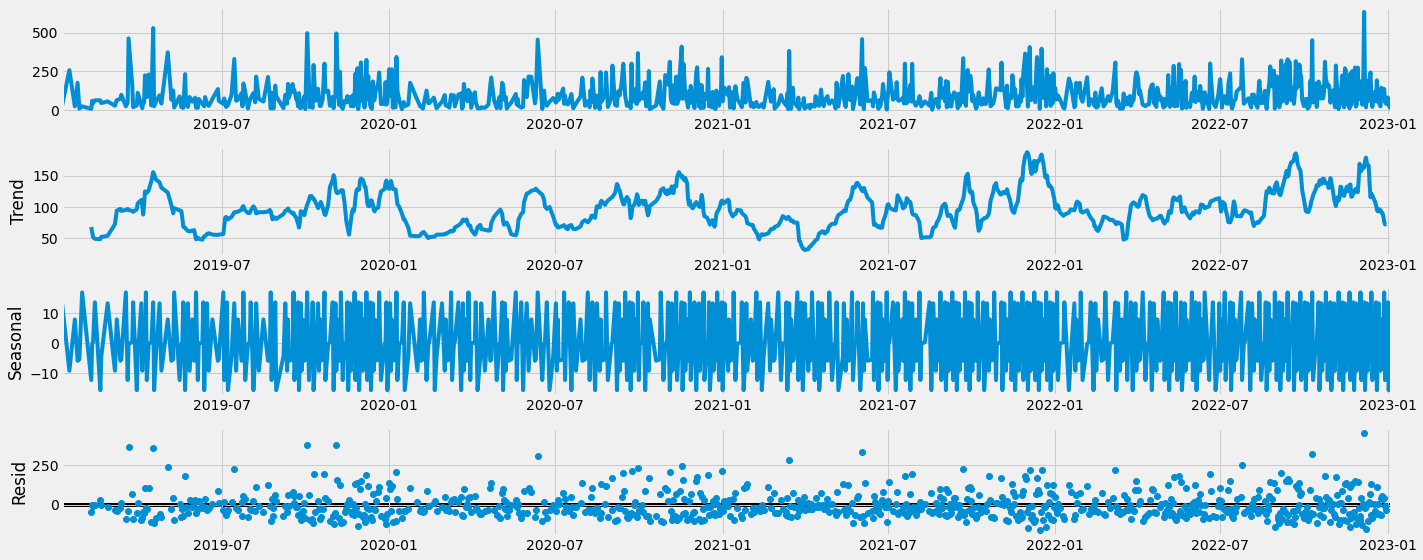

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df,model='additive', period=12)
decompose.plot()
plt.show()

# **Stationary Check**



> 1.Rolling Statistics

> 2.Duckey Fuller




In [ ]:
from statsmodels.tsa.stattools import adfuller

def get_Stationary(df):
   rolmean = df.rolling(window=12).mean()
   rolstd= df.rolling(window=12).std()

   orig = plt.plot(df, color='#ADD8E6' , label= 'Orginal')
   mean = plt.plot(rolmean, color ='red' , label='Rolling Mean')
   std = plt.plot(rolstd, color ='black' , label='Rolling Std')
   plt.legend(loc='best')
   plt.title('Rolling mean & Standard Deviation')
   plt.show(block=False)

   dftest = adfuller(df,autolag="AIC")

   dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-Value','#Lags-Used','Number of Observations Used'])
   for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

   print(dfoutput)


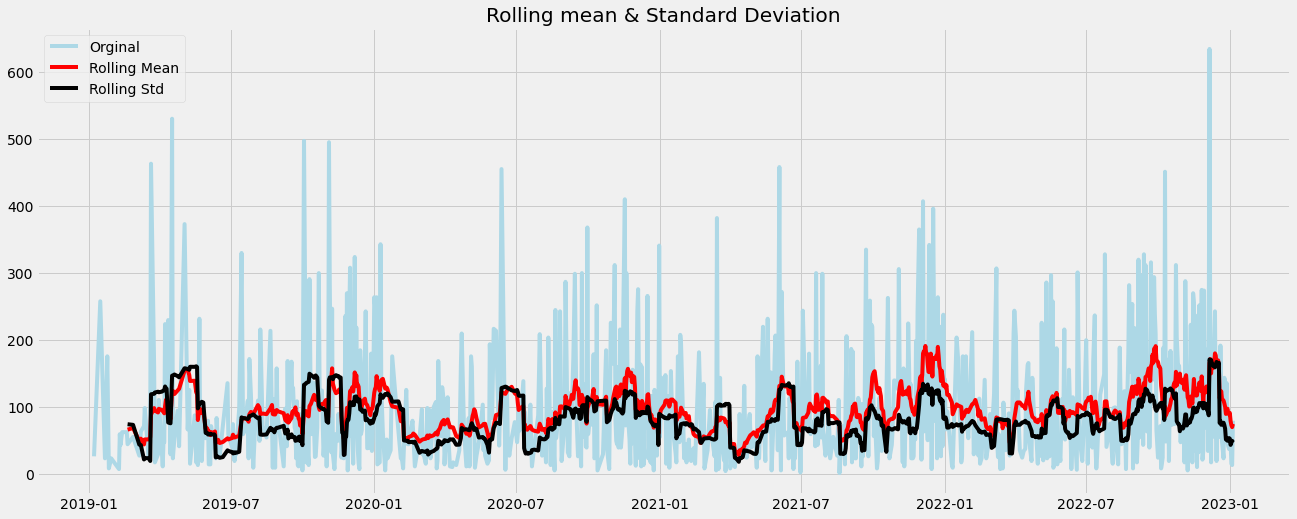

Test Statistic                -6.237681e+00
P-Value                        4.781167e-08
#Lags-Used                     1.200000e+01
Number of Observations Used    8.770000e+02
Critical Value (1%)           -3.437828e+00
Critical Value (5%)           -2.864841e+00
Critical Value (10%)          -2.568528e+00
dtype: float64


In [ ]:
get_Stationary(df)

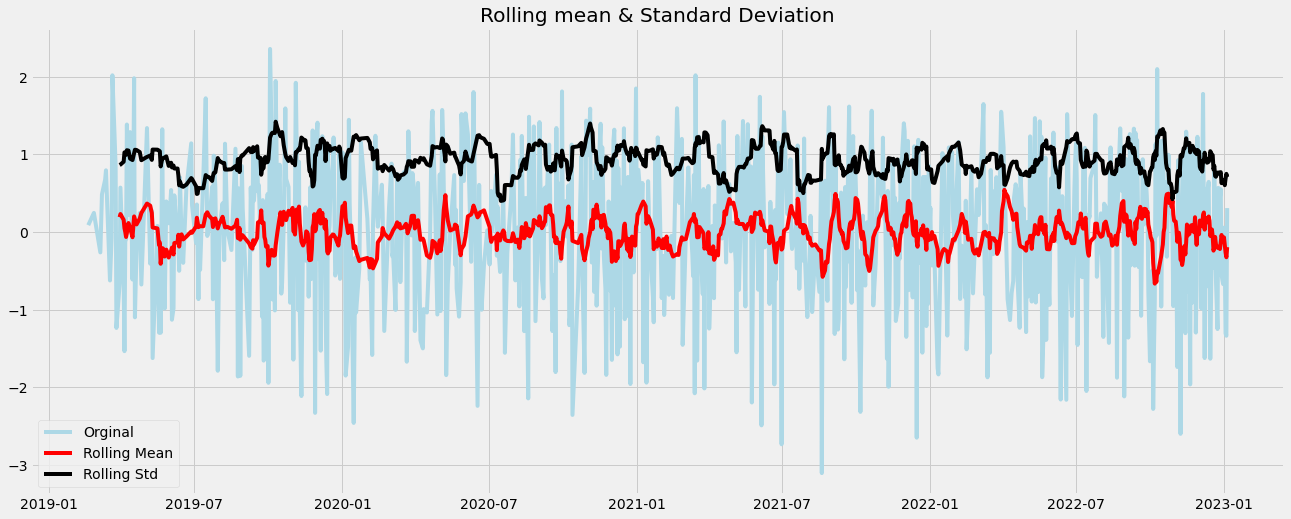

Test Statistic                -1.008146e+01
P-Value                        1.185583e-17
#Lags-Used                     1.800000e+01
Number of Observations Used    8.600000e+02
Critical Value (1%)           -3.437977e+00
Critical Value (5%)           -2.864907e+00
Critical Value (10%)          -2.568563e+00
dtype: float64


In [ ]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_Stationary(df_log_minus_mean)

**ARIMA Model parameters**


> autocorrelation plot



> partial autocorrelation plot





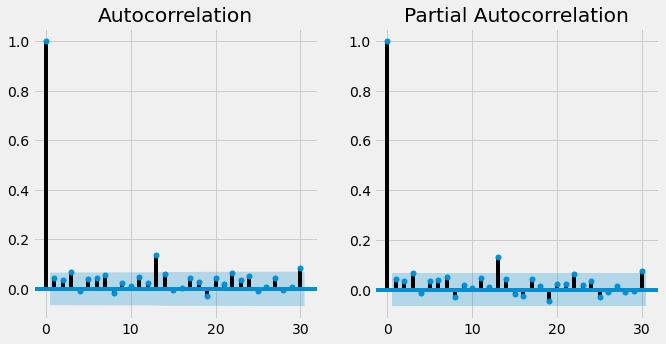

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
rcParams['figure.figsize'] = 10,5
f=plt.figure()
ax1 = f.add_subplot(121)
plot_acf(CoporateDf.Quantities,ax=ax1);
ax2 = f.add_subplot(122)
plot_pacf(CoporateDf.Quantities,ax=ax2);


**Fit ARIMA model**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



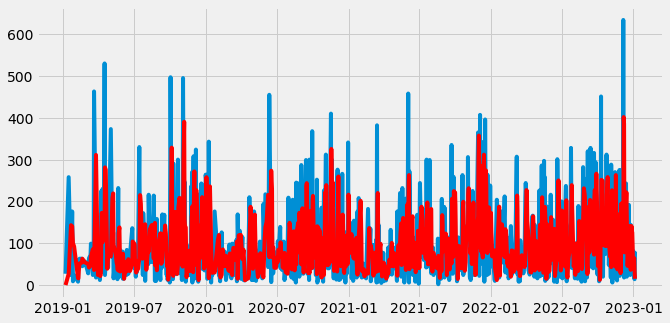

In [ ]:
import statsmodels.api as sm
arima_model = sm.tsa.arima.ARIMA(df,order=(1,1,0))
results = arima_model.fit()
plt.plot(df)
plt.plot(results.fittedvalues, color='red')



# **Time Series Using FB Prophet**

In [ ]:
!pip install pyspark
!pip install pystan~=2.14
!pip install fbprophet

from pyspark.sql.functions import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from prophet.plot import plot_plotly, plot_components_plotly
from fbprophet import Prophet

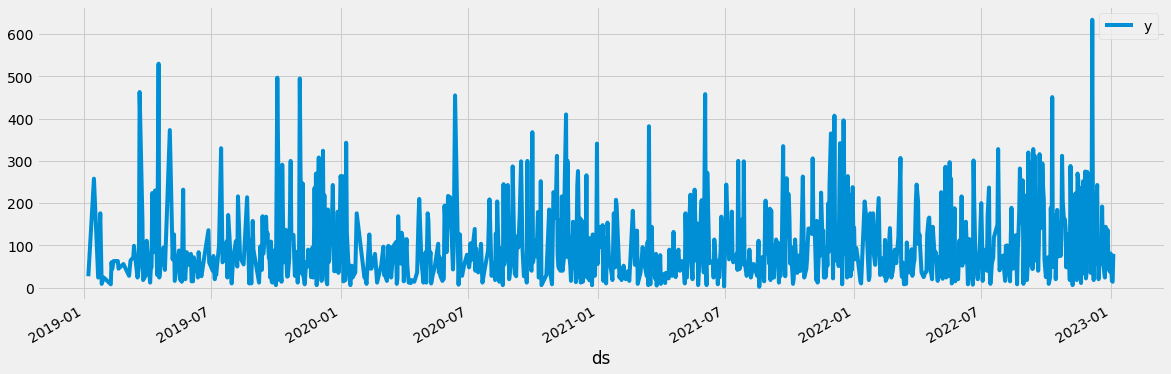

In [ ]:
df = spark.sql(""" SELECT  Ship_Date , sum(Quantity) as Quantities FROM FactOrder f left join DimCustomer c ON (f.Customer_ID = c.Customer_ID) where Segment='Corporate' group by Segment , Ship_Date """) 
df=df.toPandas()
df.sort_values(by=['Ship_Date'], inplace=True)
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], format='%Y-%m')
df['Ship_Date'].dtypes

df.columns = ['ds','y']
df.tail()
df.plot(x='ds',y='y',figsize=(18,6))


**Test , Train Set Split**

In [ ]:
train = df.iloc[:len(df)-100]
test = df.iloc[len(df)-100:]

train.head()

,ds,y
233,2019-01-07,27
396,2019-01-15,258
232,2019-01-21,24
701,2019-01-24,176
438,2019-01-26,9


In [ ]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=365) #MS for monthly, H for hourly
forecast = m.predict(future)
#forecast.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1150,2023-09-15,123.382932,7.968874,233.067423
1151,2023-09-16,121.590718,17.185233,233.670318
1152,2023-09-17,114.961544,4.290337,231.322146
1153,2023-09-18,128.827602,30.919163,239.011132
1154,2023-09-19,133.216715,17.814644,245.583670


In [ ]:
test.tail()

,ds,y
379,2023-01-01,81
329,2023-01-02,48
466,2023-01-03,16
537,2023-01-04,14
63,2023-01-05,80


In [ ]:
plot_plotly(m ,forecast)

# **Forecast with XGboost and Seaborn**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = spark.sql(""" SELECT  sum(Quantity) as Quantities,Ship_Date FROM FactOrder f left join DimCustomer c ON (f.Customer_ID = c.Customer_ID) where Segment='Corporate' group by Segment , Ship_Date """) 
df=df.toPandas()
df.sort_values(by=['Ship_Date'], inplace=True)

#print(CoporateDf.tail())
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], format='%Y-%m')
df['Ship_Date'].dtypes

df.index = df['Ship_Date']
del df['Ship_Date']
df.head()


,Quantities
Ship_Date,
2019-01-07,27
2019-01-15,258
2019-01-21,24
2019-01-24,176
2019-01-26,9


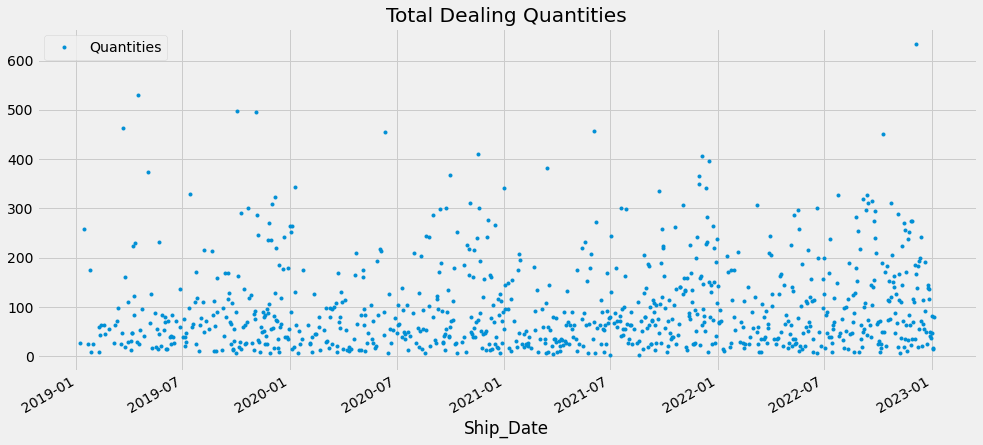

In [ ]:
df.plot(style='.',
        figsize=(15, 7),
        color=color_pal[0],
        title='Total Dealing Quantities')
plt.show()

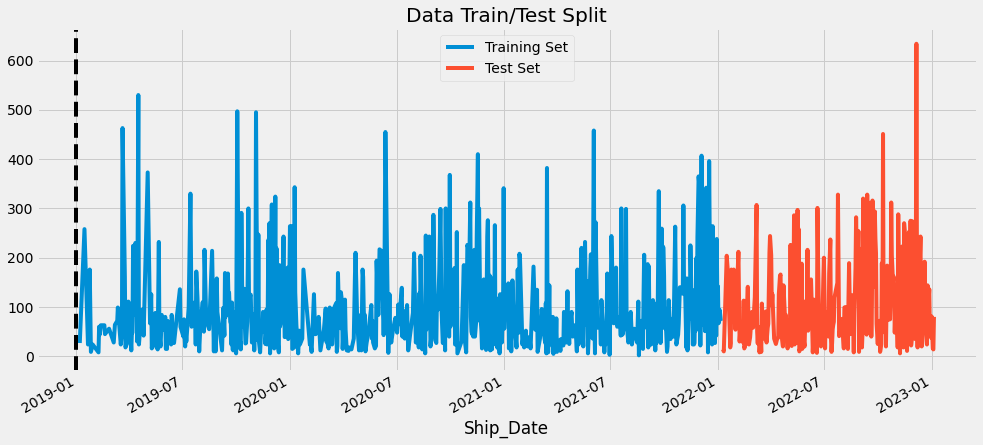

In [ ]:
train = df.loc[df.index < '01-07-2022']
test = df.loc[df.index >= '01-07-2022']

fig, ax = plt.subplots(figsize=(15, 7))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

df.head()

,Quantities,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Ship_Date,,,,,,,,,
2019-01-07,27,0,0,1,1,2019,7,7,2
2019-01-15,258,0,1,1,1,2019,15,15,3
2019-01-21,24,0,0,1,1,2019,21,21,4
2019-01-24,176,0,3,1,1,2019,24,24,4
2019-01-26,9,0,5,1,1,2019,26,26,4


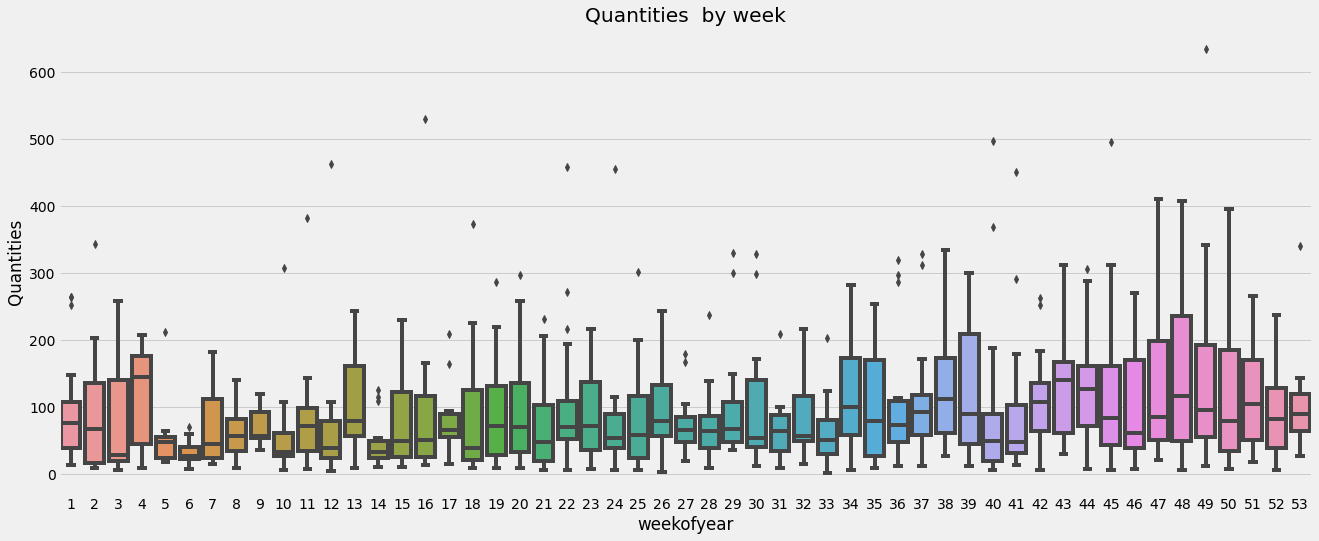

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(data=df, x='weekofyear', y='Quantities')
ax.set_title('Quantities  by week')
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Quantities'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50, 
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[05:21:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:130.19	validation_1-rmse:140.19
[100]	validation_0-rmse:92.4328	validation_1-rmse:101.213
[200]	validation_0-rmse:84.7764	validation_1-rmse:93.2832
[300]	validation_0-rmse:82.7306	validation_1-rmse:91.8713
[400]	validation_0-rmse:81.709	validation_1-rmse:91.6656
[500]	validation_0-rmse:80.7752	validation_1-rmse:91.6944
[600]	validation_0-rmse:79.6661	validation_1-rmse:91.8805
[700]	validation_0-rmse:78.5921	validation_1-rmse:92.1291
[800]	validation_0-rmse:77.3019	validation_1-rmse:92.6496
[900]	validation_0-rmse:76.3418	validation_1-rmse:93.0495
[999]	validation_0-rmse:75.5482	validation_1-rmse:93.2643


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

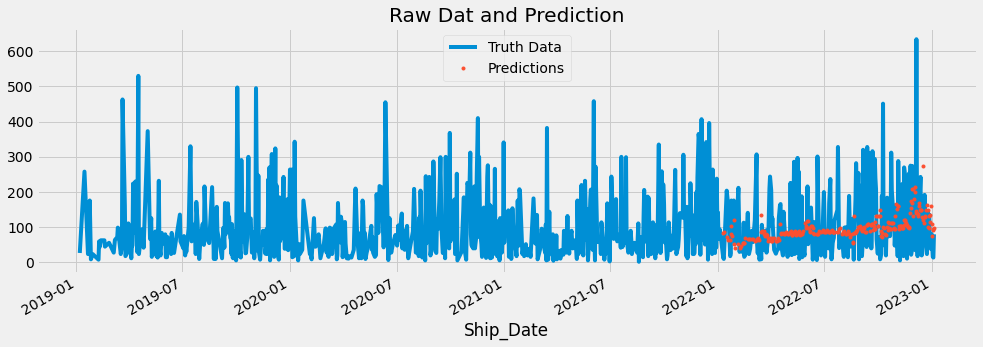

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Quantities']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['Quantities'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 93.26
